In [288]:
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg

# Préparation des données
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Modèles
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Option d'affchage
pd.set_option('display.max_columns', None)

In [289]:
# Importation de la base des données calculées

df0 = pd.read_csv('data/données_calculees.csv', index_col = 0)

# Copie de la base

df = df0.copy()

# I. Préparation des données

In [290]:
# Standardisation des données

min_max_scaler = preprocessing.MinMaxScaler()
df[[
    'Numero', 'NbPieces', 'lon', 'lat', 
    'periode_construction', 'Arrondissement', 'Quartier',
    'prixm2', 'score_commerce', 'score_commerce_lux','score_monument', 
    'score_jardin', 'score_metro'
    ]] = min_max_scaler.fit_transform(df[[
                        'Numero', 'NbPieces', 'lon', 'lat', 
                        'periode_construction', 'Arrondissement', 'Quartier',
                        'prixm2', 'score_commerce', 'score_commerce_lux','score_monument', 
                        'score_jardin', 'score_metro'
                                        ]])

In [291]:
# Encodage de la variable 'TypeVoie'

df['TypeVoie'] = df['TypeVoie'].astype(str)
le = LabelEncoder()
 
df['TypeVoie_encoded'] = le.fit_transform(df.TypeVoie)

ohe = OneHotEncoder()
 
X = ohe.fit_transform(df.TypeVoie_encoded.values.reshape(-1,1)).toarray()
 
dfOneHot = pd.DataFrame(X, columns = ["TypeVoie_"+str(int(i)) for i in range(X.shape[1])])
df = pd.concat([df, dfOneHot], axis=1).drop(columns = ['TypeVoie', 'TypeVoie_encoded']).dropna()


Les différentes modalités sont :  
0 : Allée, 1 : Avenue, 2 : Boulevard,  3 : CAR,  4 : Cité,  5 : Cour, 6 : CRS,  7 : Impasse,  8 : Passage,  9 : Place,  10 : Quai, 11 : Rue, 12 : Square, 13 : VC, 14 : Villa, 15 : nan

In [292]:
# On définit les échantillons

y = df[['prixm2']]
X = df.drop(columns = ['prixm2'])

# On choisit un échantillon de validation de 20 %

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

# II. Modélisation

On choisira la métrique MSE (mean squared error) car nous avons affaire à une variable continue.

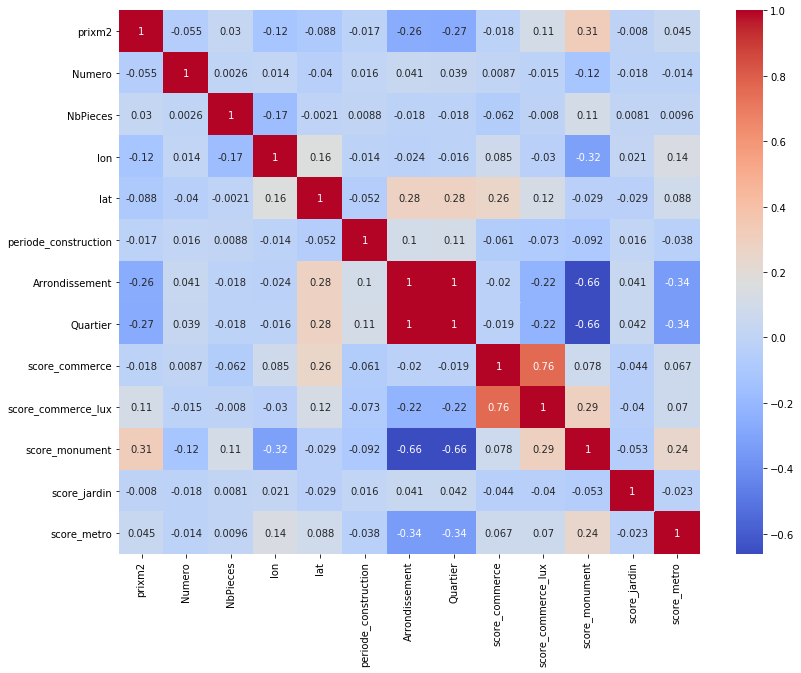

In [293]:
# Affichage de la matrice de corrélation

fig, ax = plt.subplots(figsize = (13, 10)) 
fig = sns.heatmap(df[['prixm2', 'Numero', 'NbPieces', 'lon', 'lat', 
                        'periode_construction', 'Arrondissement', 'Quartier',
                         'score_commerce', 'score_commerce_lux','score_monument', 
                        'score_jardin', 'score_metro']].corr(), cmap= 'coolwarm', annot = True)

On observe que le prix est significativement corrélé :  

- positivement à score_monument  
- négativement à Quartier et Arrondissement (qui ont un coefficient de corélation de 1 entre eux)

Habiter proche des monuments et dans les premiers Quartier/Arrondissement feraient donc monter le prix du bien.

## II.1 Regressions linéaires et polynomiales

### Regression linéaire multiple

On commence par une regression linéaire pour avoir une première idée de l'influence des variables sur le prix

In [294]:
lin_reg = LinearRegression().fit(X_train, y_train)

# On prédit à partir de l'échantillon de test pour calculer les scores

y_pred = lin_reg.predict(X_test)

In [295]:
px.histogram(pd.DataFrame([
    (X.columns[i], lin_reg.coef_[0][i]) for i in range(28)
                    ]).T.rename(index = {0 : 'variable', 1 : 'coeff'}).T, x = 'variable', y = 'coeff'
            ).show()

print('MSE :', mean_squared_error(y_test, y_pred))

MSE : 0.014810607761334024


In [296]:
# Affichage des p-values

mod = sm.OLS(y,X)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
pd.DataFrame(p_values).T

,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
P>|t|,0.000004,0.145941,0.000718,0.000019,8.428105e-25,3.540958e-26,0.036721,0.125349,0.012068,0.332379,6.746218e-115,6.591719e-08,8.649142e-43,0.0,8.259000e-274,0.049411,3.701278e-79,0.00005,1.081685e-19,1.362097e-66,1.631331e-104,1.311025e-117,3.075773e-129,0.0,1.840972e-112,1.510924e-07,1.527402e-117,0.000011


On observe que :  

- les variables avec les plus petites p-values sont les score aux commerces et score_monument
- être proche des commerces atypiques mais loin des commerces en général ferait monter le prix
- la variable qui semble être la plus significative est score_monument (p-value la plus basse sans compter les TypeVoie, et coefficient le plus grand)
- score_metro a étonnement un coefficient négatif
- Les p-values concernant TypeVoie ne semblent pas pertinentes, on manque sans doute de données pour certaines modalités

### Regressions polynomiales

Il est très probable que les variables n'aient pas un effet linéaire sur le prix au m<sup>2<sup>.
    
C'est pourquoi on choisit de faire des regressions polynomiales, en augmentant progressivement le degré, et en s'arrêtant dès qu'on observe de l'overfitting sur l'échantillon de test.

In [297]:
def poly_reg(n):
    """
    Cette fonction effectue une regression polynomiale sur la base d'entrainement et affiche 
    la MSE pour l'echantillon de test
    """
    
    # Agrandissement de la base d'entrainement avec l'ajout des degrés successifs
    poly_X = X_train.copy()
    
    for i in range(2, n+1):
        
        index = [str(j) + '^' + str(i) for j in X.columns[:12]]
        poly_X[[str(j) + '^' + str(i) for j in X.columns[:12]]] = poly_X[[j for j in X.columns[:12]]].pow(i)
    
    poly_reg = LinearRegression().fit(poly_X, y_train)
    
    # Agrandissement de la base d'de test avec l'ajout des degrés successifs
    poly_X_test = X_test.copy()
    
    for i in range(2, n+1):
        
        index = [str(j) + '^' + str(i) for j in X.columns[:12]]
        poly_X_test[[str(j) + '^' + str(i) for j in X.columns[:12]]] = poly_X_test[[j for j in X.columns[:12]]].pow(i)
    
    # Regression
    y_pred = poly_reg.predict(poly_X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Affichage des coefficients pour le degré 2
    fig = px.histogram(pd.DataFrame([
        (poly_X.columns[i], poly_reg.coef_[0][i]) for i in range(28 + 12 * (n - 1))
                            ]).T.rename(
        index = {0 : 'variable', 1 : 'coeff'}
                                        ).T.sort_values(by = 'variable'), x = 'variable', y = 'coeff') 
    
    if n == 2:
        
        fig.show()
        
    else:
        
        print('degré : ', n)

    return MSE

In [298]:
# Regressions jusqu'à l'overfitting (MSE > 0.4 sur l'échantillon test)

i = 2
val = poly_reg(2)
list_mse_degree = [val]


while val < .016:
    i += 1
    val = poly_reg(i)
    list_mse_degree.append(val) 
    
    if i > 25:
        break
    

px.line(x = [i + 2 for i in range(len(list_mse_degree))], y = list_mse_degree).show()

degré :  3
degré :  4
degré :  5
degré :  6


On observe que :  
- le degré à partir duquel on observe de l'overfitting dépend beaucoup de l'échantillon de test, qui est choisi au hasard. On a pu observer de l'overfitting au degré 25 comme au degré 8 avec des échantillons différents
- Dans la regression de degré 2, pour presque chaque variable, le coefficient de la variable et de la variable au carré ont un exposant de signe opposé. Cela semble signifier que le premier coeffient "compense" l'effet du deuxième, et donc que l'effet de chaque variable est plus complexe qu'un effet linéaire
- Seul score_monument a significativement deux coefficients positif. Son effet semble clair : plus on est proche des monuments, plus le prix est haut

In [299]:
# Pour obtenir de nouveaux échantillons si échec :  
y = df[['prixm2']]
X = df.drop(columns = ['prixm2'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

## II.2 Regression pénalisée

Etant donnée le grand nombre de variables dont nous disposons, il nous parrait cohérent d'utiliser une regression pénalisée afin de sélectionner les variables les plus significatives.
De plus, certaines de nos variables sont corrélées entre elles.

Ici, on a fait baisser l1_ratio progressivement jusqu'à obtenir 10 variables dont les coefficients sont non nul.

In [300]:
EN_reg = ElasticNet(alpha=.1, copy_X=True, fit_intercept = False, l1_ratio=.05)

EN_reg.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=0.05,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [301]:
y_pred = EN_reg.predict(X_test)
print('MSE : ', mean_squared_error(y_test, y_pred))

MSE :  0.017735200149712065


In [302]:
pd.DataFrame([(X.columns[i], EN_reg.coef_[i]) for i in range(28)]).T.rename(index = {0 : 'variable', 1 : 'coeff'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
variable,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
coeff,0,0,0.0470961,0.0344645,0,0.00686595,0.0255302,0.0359894,0.037683,0,0.114598,0,0,0.0187615,0.00383807,0,0,0,0,0,0,0,0,0.0681002,0,0,0,0


On observe que :  
- score_monument semble être la variable la plus importante
- la longitude est plus importante que la latitude  
- les TypeVoie les plus importants sont Avenue, Rue et Boulevard

In [303]:
# On retient alors les variables suivantes

signif_EN = ['lon', 'lat', 'score_commerce_lux', 'periode_construction', 'Arrondissement', 'Quartier', 
   'score_monument', 'TypeVoie_1', 'TypeVoie_2', 'TypeVoie_11', ]

## II.3 Regression par Random Forest

Dans cette partie, nous allons faire des regressions grâce aux arbres de décision. 
Nous allons rechercher les meilleurs paramètres pour notre regression.
Pour cela, on teste un à un les paramètres suivants :  
- profondeur des arbres  
- nombre d'arbres  
- minimun d'exemples requis pour splitter l'arbre  
- nombre de feuilles maximum par arbre  

In [304]:
# On définit d'abord une fonction qui donne l'importance des variables vis à vis d'un certain modèle

def feat_importance(model, x_train, y_train, X):
    """
    Renvoie le tableau de l'importance des variables vis à vis du modèle par la méthode des permutations
    """

    result = permutation_importance(
                                    model, 
                                    X, 
                                    y, 
                                    n_repeats = 3,
                                    random_state = 0
                                    )['importances_mean']
    
    importance = pd.DataFrame(result, index = X.columns, columns = ["Importance"])
    
    return importance.sort_values(by = ['Importance'], ascending = False)

In [305]:
# Création des essembles de tests et d'entrainement, on choisit une taile de test de 30% ici

X = df.drop(['prixm2'], axis = 1)
x = np.array(X)
y = np.array(df['prixm2'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 41)
# random_state correspond à la graine générant l'échantillon aléatoire

### II.3.1 Profondeur maximale

In [306]:
max_depth_ls = [1, 10, 13, 15, 17, 20, 25, 30] # profondeurs maximales des arbres de décision testées
mse_train_max_depth = []
mse_test_max_depth = []

# Pour chaque profondeur max, on regresse avec random forest

for m in max_depth_ls :
    
    print('Profondeur téstée : ', m)
    
    rf = RandomForestRegressor(
                            max_depth = m, 
                            random_state=0,
                            n_estimators = 30) # nombre d'arbres utilisés
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_max_depth.append(mean_squared_error(y_train, y_pred_train))
    mse_test_max_depth.append(mean_squared_error(y_test, y_pred))

Profondeur téstée :  1
Profondeur téstée :  10
Profondeur téstée :  13
Profondeur téstée :  15
Profondeur téstée :  17
Profondeur téstée :  20
Profondeur téstée :  25
Profondeur téstée :  30


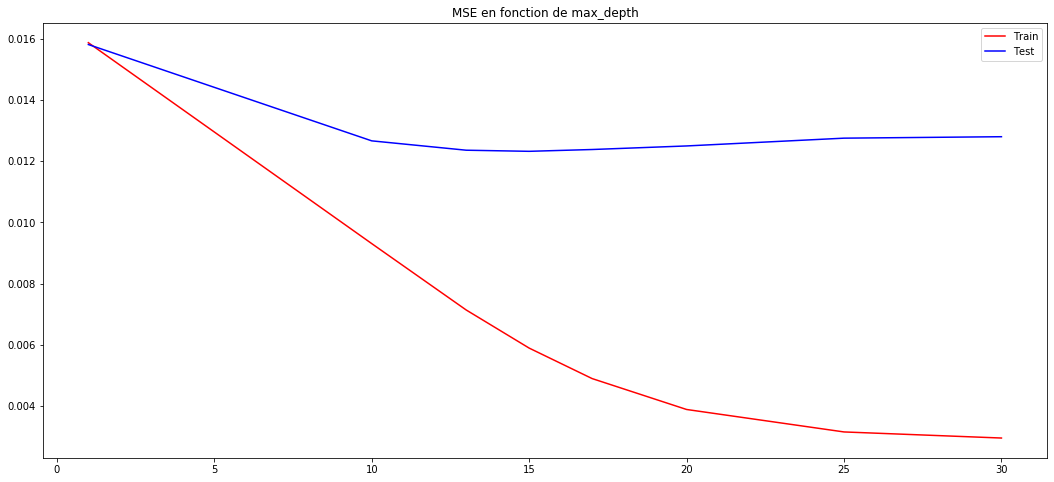

In [307]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(max_depth_ls, mse_train_max_depth, color = 'red', label = 'Train')
plt.plot(max_depth_ls, mse_test_max_depth, color = 'blue', label = 'Test')
plt.title('MSE en fonction de max_depth')
plt.legend()
plt.show()

On observe que l'overfitting débute après max_depth > 15 (le score sur l'échantillon d'entrainement continue de decroitre alors qu'il commence à croitre sur l'échantillon de test)

In [308]:
#On regarde la valeur qui minimise la MSE sur l'ensemble de test

max_depth_ls[mse_test_max_depth.index(min(mse_test_max_depth))]

15

**On garde donc max_depth = 15 pour la suite**

### II.3.2 Nombre d'arbres

In [309]:
# On regarde maintenant l'effet du nombre d'arbre sur l'effet de la regression

nb_estimators_ls = [1, 2, 3, 5, 20, 40, 50, 60, 80]
mse_train_nb_estimators = []
mse_test_nb_estimators = []

for m in nb_estimators_ls :
    print("Nombre d'arbres testés : ", m)
    rf = RandomForestRegressor(max_depth = 15, 
                               random_state = 0,
                                n_estimators = m)    
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_nb_estimators.append(mean_squared_error(y_train, y_pred_train))
    mse_test_nb_estimators.append(mean_squared_error(y_test, y_pred))


Nombre d'arbres testés :  1
Nombre d'arbres testés :  2
Nombre d'arbres testés :  3
Nombre d'arbres testés :  5
Nombre d'arbres testés :  20
Nombre d'arbres testés :  40
Nombre d'arbres testés :  50
Nombre d'arbres testés :  60
Nombre d'arbres testés :  80


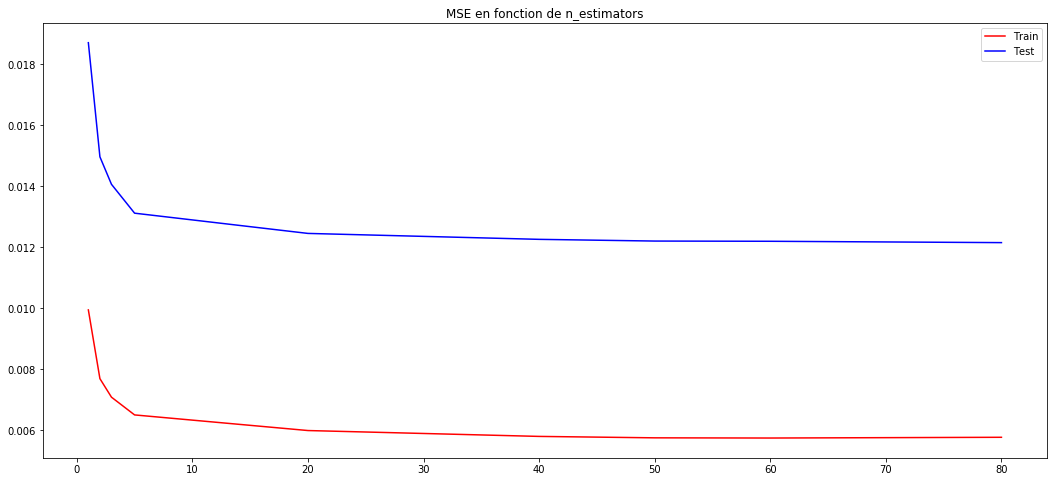

In [310]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(nb_estimators_ls, mse_train_nb_estimators, color = 'red', label = 'Train')
plt.plot(nb_estimators_ls, mse_test_nb_estimators, color = 'blue', label = 'Test')
plt.title('MSE en fonction de n_estimators')
plt.legend()
plt.show()

**La courbe semble strictement décroissante, on doit arbitrer entre complexité algorithmique et performance.  
On garde n_estimators = 60 pour la suite**

### II.3.3 Minimun d'exemples requis pour splitter l'arbre  

In [311]:
# On fait varier le nombre minimum d'exemple requis pour créer une feuille/noeud

samples_leaf_ls = [1, 2, 3, 4, 10]
mse_train_samples_leaf = []
mse_test_samples_leaf = []


for m in samples_leaf_ls :
    print('min_samples_leaf testé : ', m)
    rf = RandomForestRegressor( max_depth = 15, 
                                min_samples_leaf = m,
                                n_estimators = 60, 
                                random_state = 0
                              )    
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_samples_leaf.append(mean_squared_error(y_train, y_pred_train))
    mse_test_samples_leaf.append(mean_squared_error(y_test, y_pred))

min_samples_leaf testé :  1
min_samples_leaf testé :  2
min_samples_leaf testé :  3
min_samples_leaf testé :  4
min_samples_leaf testé :  10


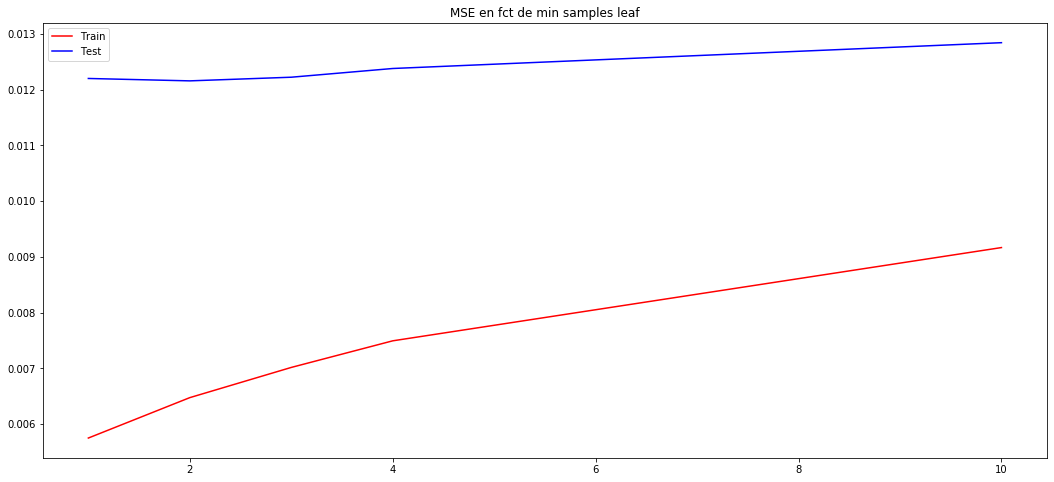

In [312]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(samples_leaf_ls, mse_train_samples_leaf, color='red', label='Train')
plt.plot(samples_leaf_ls, mse_test_samples_leaf, color='blue', label='Test')
plt.title('MSE en fct de min samples leaf')
plt.legend()
plt.show()

**On garde donc min_samples_leaf = 1 pour la suite**

### II.3.4 Nombre maximum de feuilles par arbres

In [313]:
max_leaf_ls = [2, 10, 100, 150, 200, 1000, 1500]
mse_train_max_leaf = []
mse_test_max_leaf = []



for m in max_leaf_ls :
    
    print('Nombre de feuilles max testé : ', m)
    rf = RandomForestRegressor(max_depth = 15, 
                               min_samples_leaf = 1, 
                               max_leaf_nodes = m,
                               n_estimators = 60)   
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    mse_train_max_leaf.append(mean_squared_error(y_train, y_pred_train))
    mse_test_max_leaf.append(mean_squared_error(y_test, y_pred))

Nombre de feuilles max testé :  2
Nombre de feuilles max testé :  10
Nombre de feuilles max testé :  100
Nombre de feuilles max testé :  150
Nombre de feuilles max testé :  200
Nombre de feuilles max testé :  1000
Nombre de feuilles max testé :  1500


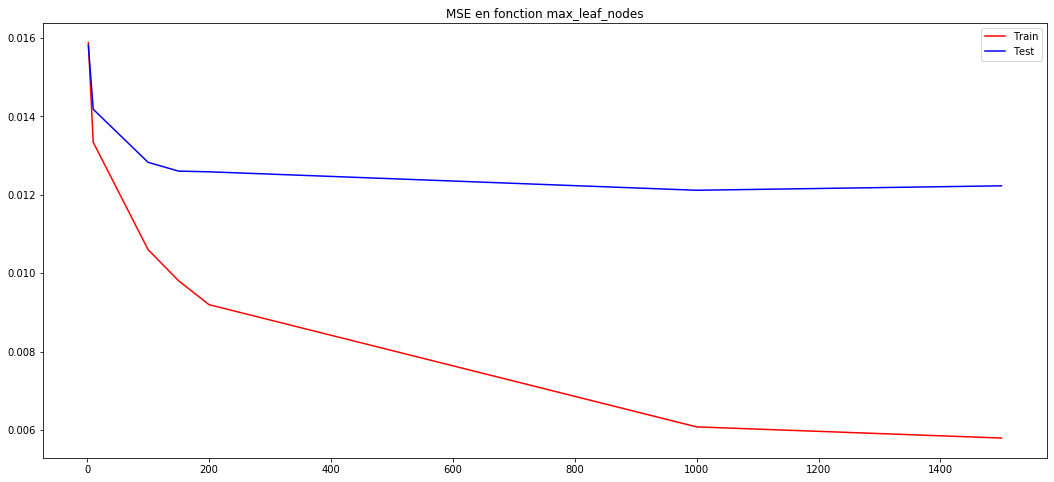

In [314]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(max_leaf_ls, mse_train_max_leaf, color = 'red', label = 'Train')
plt.plot(max_leaf_ls, mse_test_max_leaf, color = 'blue', label = 'Test')
plt.title('MSE en fonction max_leaf_nodes')
plt.legend()
plt.show()

**La courbe semble strictement décroissante, on doit arbitrer entre complexité algorithmique et performance.  
On garde max_leaf_nodes = 1000 pour la suite**

MSE train :  0.00611886123788709
MSE test :  0.012195654825994261
MSE modèle nulle :  0.06630114745925716


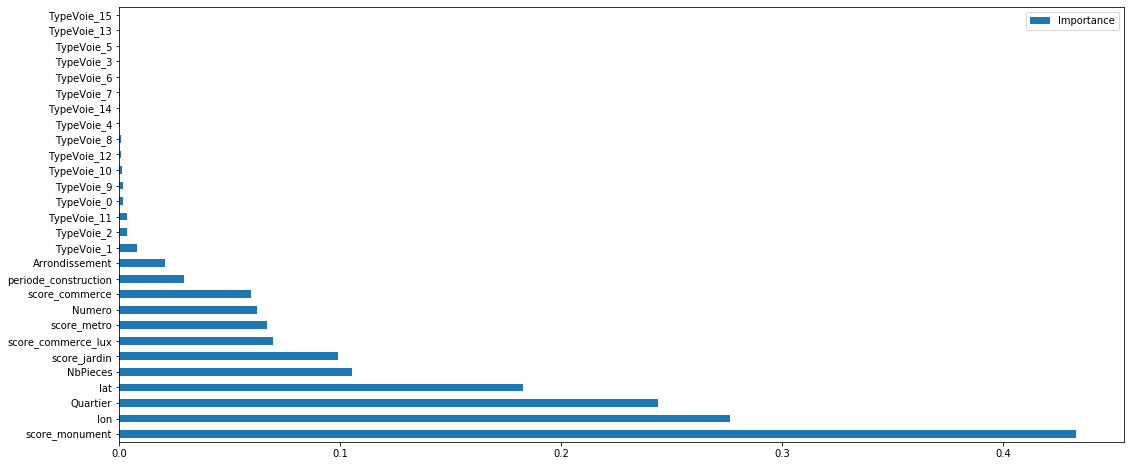

In [315]:
# On a maintenant tous nos paramètres

rf = RandomForestRegressor(
                        max_depth = 15, 
                        min_samples_leaf = 1, 
                        max_leaf_nodes = 1000,
                        n_estimators = 60
                            )    

rf = rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
y_pred = rf.predict(x_test)
oo = np.zeros(y_pred.shape)

print('MSE train : ', mean_squared_error(y_train, y_pred_train))
print('MSE test : ', mean_squared_error(y_test, y_pred))
print('MSE modèle nulle : ', mean_squared_error(y_test, oo))

importance = feat_importance(rf, x_train, y_train, X)

importance.plot(kind = 'barh', figsize = (18, 8))

In [316]:
print('Rappel des variables retenue par ElasticNet : ', signif_EN)

Rappel des variables retenue par ElasticNet :  ['lon', 'lat', 'score_commerce_lux', 'periode_construction', 'Arrondissement', 'Quartier', 'score_monument', 'TypeVoie_1', 'TypeVoie_2', 'TypeVoie_11']


- On retrouve la présence de score_monument comme variable la plus importante, et on retrouve globalement les mêmes variables importantes.  
- On retrouve que la longitude est plus importante que la latitude.  
- On note aussi que les TypeVoie les plus importantes sont les 1, 2 et 11 (Avenue, Boulevard, Rue). 
- Par contre, Quartier surpasse Arrondissement de beaucoup, comme ces deux variables sont très corrélées, cela ne pose pas de problème de cohérence.
- NbPieces, et les scores pour les jardins, le metro et les commerce sont plus iportants ici.


MSE train :  0.006121477353946974
MSE test :  0.012269850270773902
MSE model nulle :  0.06630114745925716


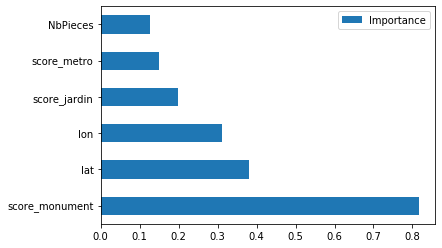

In [317]:
# On garde que les variables raisonnablement significatives (>0.01)

X = df[['score_monument', 'lon', 'lat', 'NbPieces', 'score_jardin', 'score_metro']]

x = np.array(X)
y = np.array(df['prixm2'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 41)

rf = RandomForestRegressor(max_depth = 15, random_state = 0, min_samples_leaf = 1, max_leaf_nodes = 1000,
                                 n_estimators = 60)
rf = rf.fit(x_train,y_train)


y_pred = rf.predict(x_test)
y_pred_train= rf.predict(x_train)

oo = np.zeros(y_pred.shape)

print('MSE train : ', mean_squared_error(y_train, y_pred_train))
print('MSE test : ', mean_squared_error(y_test, y_pred))
print('MSE model nulle : ', mean_squared_error(y_test, oo))

importance = feat_importance(rf, x_train, x_test, X)
importance.plot(kind='barh')

On retrouve exactement les mêmes résultats, sauf que la latitude a dépassé la longitude.

## II.4 Réseau de neurones

Les réseaux de neurones sont des architectures qui permettent de rendre compte des influences complexes des variables sur le prix.

In [318]:
# On définit les échantillons

y = df[['prixm2']]
X = df.drop(columns = ['prixm2'])

Après plusieurs essais, un réseau 28 - 2 - 3 - 1 fournit des résultats satisfaisant. 

In [319]:
# Construction de l'architecture du réseau

model = Sequential()

model.add(Dense(2, input_dim = 28, activation = 'relu'))
model.add(Dense(3))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [320]:
# Lancement de la phase d'apprentissage

history = model.fit(X, y, validation_split = 0.2,  epochs = 30)

Train on 19972 samples, validate on 4993 samples
Epoch 1/30
19972/19972 [==============================] - 1s 61us/step - loss: 0.0216 - val_loss: 0.0129
Epoch 2/30
19972/19972 [==============================] - 1s 72us/step - loss: 0.0172 - val_loss: 0.0121
Epoch 3/30
19972/19972 [==============================] - 1s 57us/step - loss: 0.0165 - val_loss: 0.0119
Epoch 4/30
19972/19972 [==============================] - 1s 48us/step - loss: 0.0162 - val_loss: 0.0123
Epoch 5/30
19972/19972 [==============================] - 1s 47us/step - loss: 0.0160 - val_loss: 0.0119
Epoch 6/30
19972/19972 [==============================] - 1s 47us/step - loss: 0.0158 - val_loss: 0.0120
Epoch 7/30
19972/19972 [==============================] - 1s 50us/step - loss: 0.0157 - val_loss: 0.0119
Epoch 8/30
19972/19972 [==============================] - 1s 50us/step - loss: 0.0155 - val_loss: 0.0125
Epoch 9/30
19972/19972 [==============================] - 1s 48us/step - loss: 0.0154 - val_loss: 0.0119
Epoch 

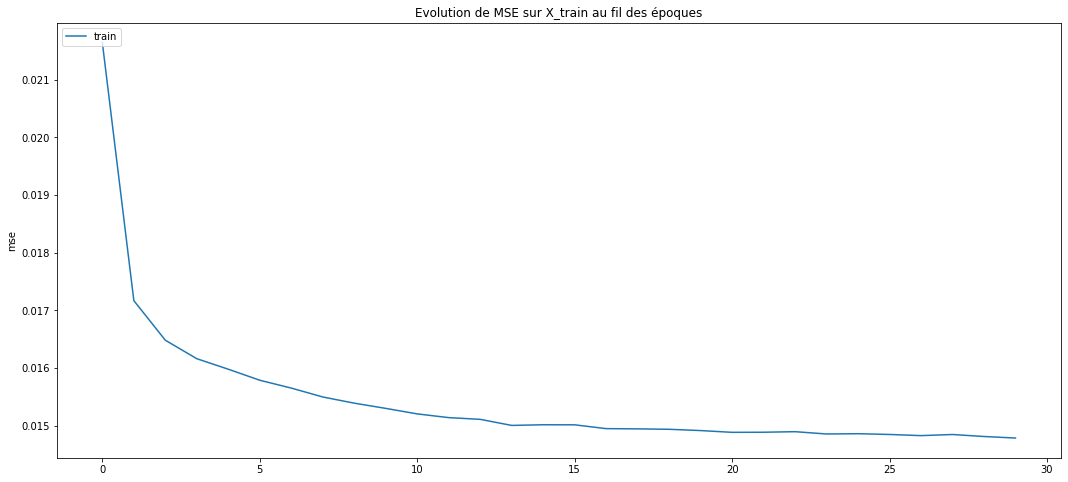

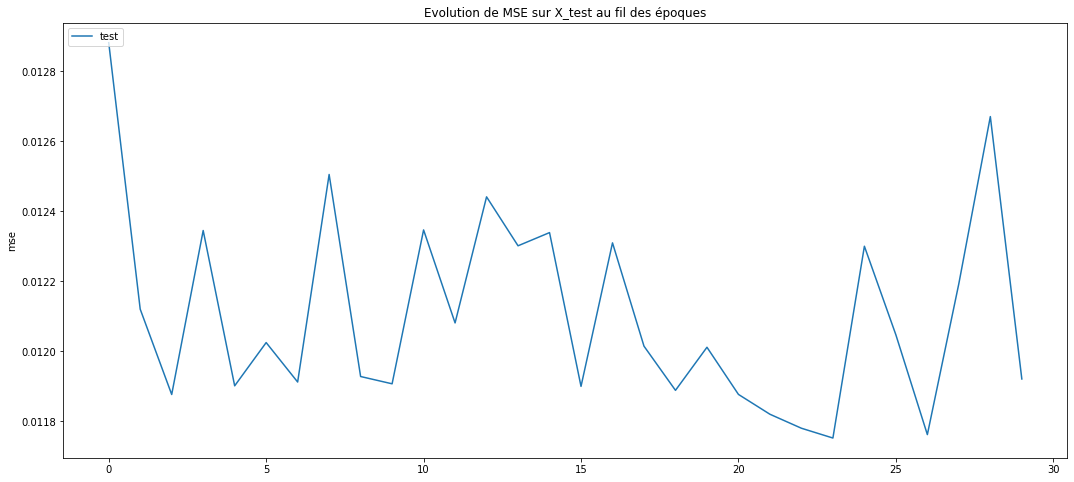

In [321]:
# On affiche l'évolution de la loss au fil des époques pour les échantillons train et test.

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history.history['loss'])
plt.title('Evolution de MSE sur X_train au fil des époques')
plt.ylabel('mse')
plt.legend(['train'], loc = 'upper left')
plt.show()

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history.history['val_loss'])
plt.title('Evolution de MSE sur X_test au fil des époques')
plt.ylabel('mse')
plt.legend(['test'], loc = 'upper left')
plt.show()

 **En prenant en compte les variables sélectionnées par ElsaticNet précédemment**

In [322]:
X_significatif = X[signif_EN]

In [323]:
# On reprend la même architecture en changeant le nombre de neurones d'entrée.

model_significatif = Sequential()

model_significatif.add(Dense(2, input_dim = 10, activation='relu'))
model_significatif.add(Dense(3))
model_significatif.add(Dense(1))

model_significatif.compile(optimizer = 'adam', loss = 'mse')

In [324]:
# Lancement de la phase d'apprentissage

history_significatif = model_significatif.fit(X_significatif, y, validation_split = 0.2,  epochs = 30)

Train on 19972 samples, validate on 4993 samples
Epoch 1/30
19972/19972 [==============================] - 1s 64us/step - loss: 0.0185 - val_loss: 0.0175
Epoch 2/30
19972/19972 [==============================] - 1s 63us/step - loss: 0.0173 - val_loss: 0.0150
Epoch 3/30
19972/19972 [==============================] - 1s 55us/step - loss: 0.0168 - val_loss: 0.0139
Epoch 4/30
19972/19972 [==============================] - 1s 53us/step - loss: 0.0166 - val_loss: 0.0123
Epoch 5/30
19972/19972 [==============================] - 1s 48us/step - loss: 0.0165 - val_loss: 0.0128
Epoch 6/30
19972/19972 [==============================] - 1s 52us/step - loss: 0.0165 - val_loss: 0.0127
Epoch 7/30
19972/19972 [==============================] - 1s 49us/step - loss: 0.0165 - val_loss: 0.0122
Epoch 8/30
19972/19972 [==============================] - 1s 54us/step - loss: 0.0165 - val_loss: 0.0120
Epoch 9/30
19972/19972 [==============================] - 1s 68us/step - loss: 0.0165 - val_loss: 0.0125
Epoch 

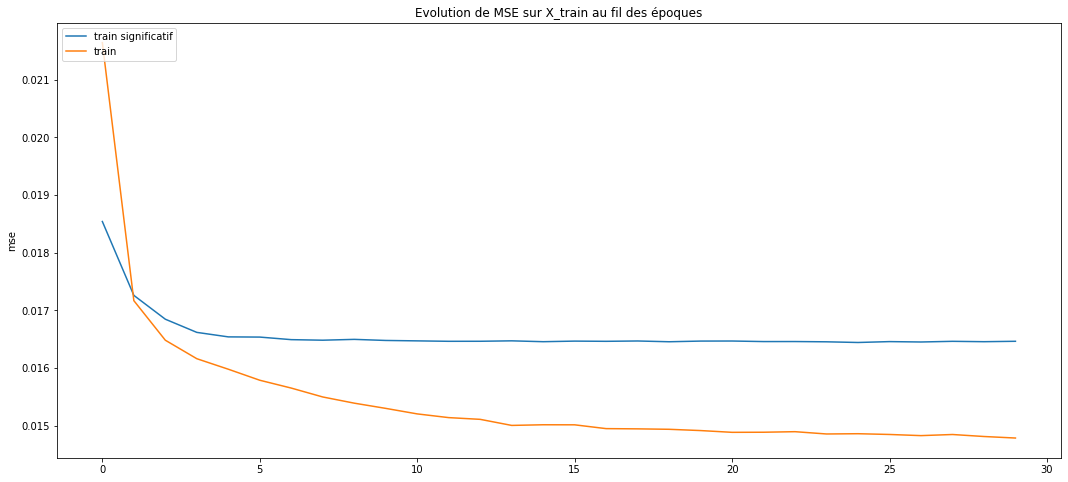

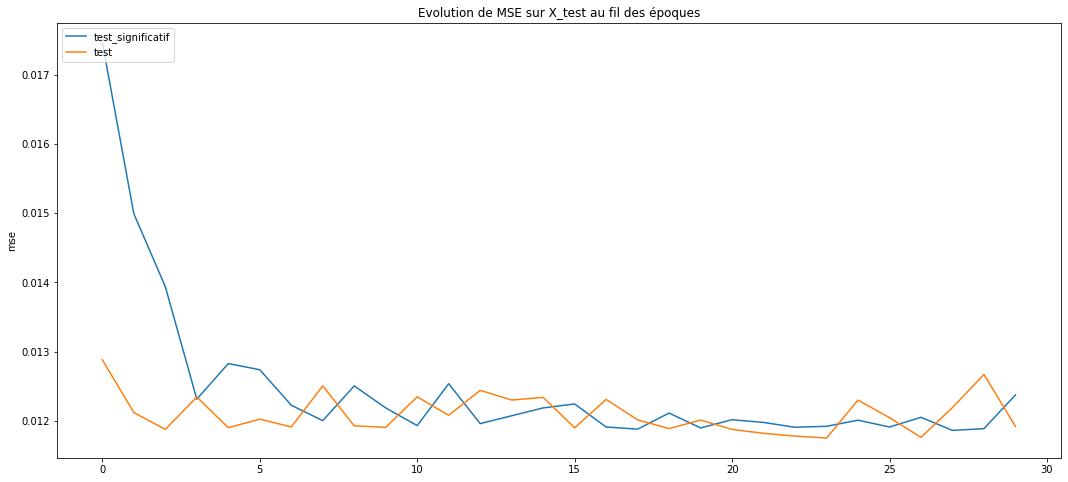

In [325]:
# On affiche l'évolution de la loss au fil des époques pour les échantillons 
# train et test en comparant avec l'autre réseau.

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(np.array(history_significatif.history['loss']))
plt.title('Evolution de MSE sur X_train au fil des époques')
plt.plot(history.history['loss'])
plt.ylabel('mse')
plt.legend(['train significatif', 'train'], loc='upper left')
plt.show()

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history_significatif.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolution de MSE sur X_test au fil des époques')
plt.ylabel('mse')
plt.legend(['test_significatif', 'test'], loc='upper left')
plt.show()

Observations :  
- le comportement de la loss dépend de la sélection de l'échantillon de test. On a pu avoir des modèles qui apprenaient bien (décroissance de la loss dans les 4 graphiques précedents), comme des modèles qui apprenaient mal.
- La plupart du temps, on observe quand même un apprentissage qui fonctionne. Mais les performance des deux réseaux sont après 15 époques similaires (l'apprentissage avec plus de variable est même plus efficace avec peu d'époques)

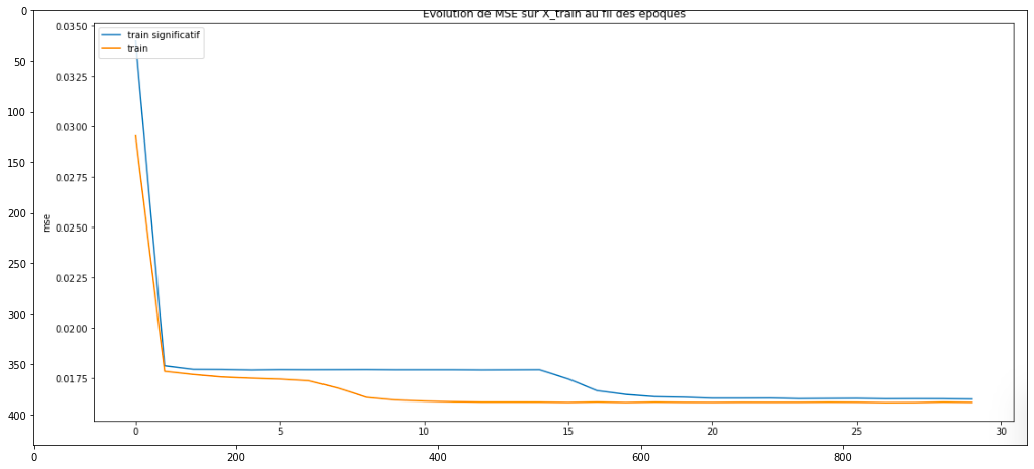

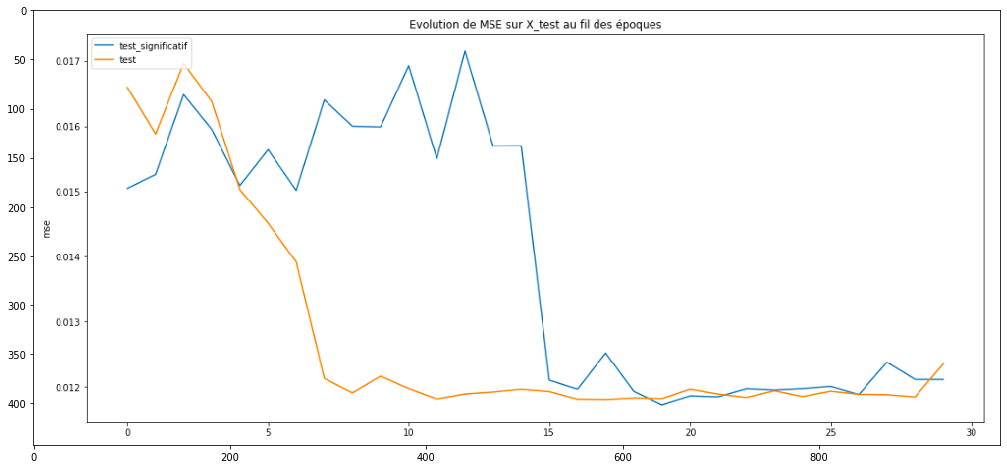

In [326]:
#Graphiques obtenus dans une bonne situation

fig, ax = plt.subplots(figsize = (18, 8))
img = mpimg.imread('img/img0.png')
imgplot = plt.imshow(img)
plt.show()

fig, ax = plt.subplots(figsize = (18, 8))
img = mpimg.imread('img/img1.png')
imgplot = plt.imshow(img)
plt.show()

**Importance des paramètres (méthode des permutations)**

In [327]:
perm = PermutationImportance(model_significatif, scoring = 'r2', random_state = 1).fit(X_significatif,y)
eli5.show_weights(perm, feature_names = X_significatif.columns.tolist())

Weight,Feature
0.1356 ± 0.0052,score_monument
0.0410 ± 0.0029,Arrondissement
0.0115 ± 0.0017,Quartier
0.0100 ± 0.0019,TypeVoie_1
0.0033 ± 0.0011,lat
0.0011 ± 0.0003,TypeVoie_11
0.0007 ± 0.0003,periode_construction
0.0001 ± 0.0001,lon
0.0000 ± 0.0002,score_commerce_lux
0.0000 ± 0.0000,TypeVoie_2


On constate ici en général l'importance du score_monument, largement les plus important selon ce modèle (poids 10 fois supérieur aux autres variables).
On retrouve aussi l'importance du Quartier et de la longitude.

# III. Clustering

Dans cette partie, nous voulons classer les appartements en différents cluster, afin d'identifier des appartements "types", regroupant les mêmes caractéristiques classiques.  
Nous procédons alors à une ACP pour réduire la dimension de nos données, puis nous utilisons la méthode des k moyennes pour le clustering. 
On pondère chaque variable par son importance donnée dans le réseau de neurones précedemment.

In [328]:
df_ACP = df[signif_EN].copy()

In [329]:
df_ACP['Arrondissement'] *= 0.0045
df_ACP['Quartier'] *= 0.0167
df_ACP['score_monument'] *= 0.0555
df_ACP['TypeVoie_1'] *= 0.0030
df_ACP['lat'] *= 0.0003
df_ACP['lon'] *= 0.0087
df_ACP['score_commerce_lux'] *= 0.0004
df_ACP['TypeVoie_11'] *= 0.0003
df_ACP['periode_construction'] *= 0.0004
df_ACP['TypeVoie_2'] *= 0.0008

In [330]:
# On réduit sur 3 variables

pca = PCA(n_components = 3)
pca.fit(df_ACP)

transformed_df = pd.DataFrame(pca.transform(df_ACP)).rename(columns = {
                            0 : 'var0', 
                            1 : 'var1', 
                            2 : 'var2',
                         })

In [331]:
px.scatter_3d(transformed_df.sample(1000), x = 'var0', y = 'var1', z = 'var2', opacity = 1)

On peut retrouver dans cette représentation une "hélice", qui fait penser aux arrondissements de Paris disposés en escargot. Cela suggère une forte composante géographique.

In [332]:
# On distinguera alors 6 clusters.

kmeans = KMeans(n_clusters = 6).fit(transformed_df)

In [333]:
# On labélise

transformed_df['cluster'] = kmeans.labels_

In [334]:
px.scatter_3d(transformed_df.sample(1000), x = 'var0', y = 'var1', z = 'var2', color = 'cluster', opacity = .7)

Les clusters ont bien été faits.

**On affiche ensuite les différentes caractéristiques des clusters obtenus.**

In [335]:
df_cluster0 = df_ACP.iloc[[i for i in list(transformed_df[transformed_df['cluster'] == 0].index)]]
df_cluster1 = df_ACP.iloc[[i for i in list(transformed_df[transformed_df['cluster'] == 1].index)]]
df_cluster2 = df_ACP.iloc[[i for i in list(transformed_df[transformed_df['cluster'] == 2].index)]]
df_cluster3 = df_ACP.iloc[[i for i in list(transformed_df[transformed_df['cluster'] == 3].index)]]
df_cluster4 = df_ACP.iloc[[i for i in list(transformed_df[transformed_df['cluster'] == 4].index)]]
df_cluster5 = df_ACP.iloc[[i for i in list(transformed_df[transformed_df['cluster'] == 5].index)]]

In [336]:
display(df_cluster0.describe().T[['mean', 'std']].T)
display(df_cluster1.describe().T[['mean', 'std']].T)
display(df_cluster2.describe().T[['mean', 'std']].T)
display(df_cluster3.describe().T[['mean', 'std']].T)
display(df_cluster4.describe().T[['mean', 'std']].T)
display(df_cluster5.describe().T[['mean', 'std']].T)

,lon,lat,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_monument,TypeVoie_1,TypeVoie_2,TypeVoie_11
mean,0.004773,0.000182,0.000094,0.000106,0.001321,0.005064,0.030225,0.000104,0.000037,0.000266
std,0.000977,0.000044,0.000076,0.000070,0.000653,0.002348,0.003612,0.000550,0.000168,0.000095


,lon,lat,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_monument,TypeVoie_1,TypeVoie_2,TypeVoie_11
mean,0.003943,0.000178,0.000072,0.000120,0.003013,0.011039,0.020573,0.000216,0.000077,0.000231
std,0.001887,0.000063,0.000060,0.000074,0.000922,0.003260,0.002383,0.000776,0.000236,0.000126


,lon,lat,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_monument,TypeVoie_1,TypeVoie_2,TypeVoie_11
mean,0.006058,0.000171,0.000033,0.000130,0.003876,0.014150,0.003849,0.000337,0.000050,0.000226
std,0.002305,0.000086,0.000053,0.000076,0.000656,0.002386,0.002473,0.000948,0.000193,0.000129


,lon,lat,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_monument,TypeVoie_1,TypeVoie_2,TypeVoie_11
mean,0.004269,0.000139,0.000096,0.000106,0.000961,0.003795,0.043464,0.000172,0.000046,0.000256
std,0.000857,0.000029,0.000074,0.000069,0.000584,0.002087,0.004397,0.000698,0.000187,0.000107


,lon,lat,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_monument,TypeVoie_1,TypeVoie_2,TypeVoie_11
mean,0.004007,0.000158,0.000057,0.000127,0.003329,0.012176,0.012482,0.000242,0.000038,0.000243
std,0.001894,0.000093,0.000065,0.000075,0.000608,0.002131,0.002262,0.000816,0.000171,0.000118


,lon,lat,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_monument,TypeVoie_1,TypeVoie_2,TypeVoie_11
mean,0.002711,0.000159,0.000065,0.000128,0.003553,0.012963,0.030443,0.000375,0.000071,0.000218
std,0.000994,0.000060,0.000065,0.000071,0.000274,0.000934,0.003435,0.000992,0.000228,0.000134


On affiche le résultat dans un plan.

In [337]:
df_ACP['cluster'] = pd.Series(kmeans.labels_)
df_ACP[['true_lat', 'true_lon']] = df0[['lat', 'lon']]

px.scatter(df_ACP, x = 'true_lon', y = 'true_lat', color = 'cluster', template = 'none', opacity = .3, color_continuous_scale = 'Jet')

On a en effet un clustering très géographique. On peut essayer d'interpréter les clusters :   
- Quartiers populaires (19ème, 20ème, une partie du 18ème et l'extrême sud)
- Quartiers familiaux (12ème, 13ème, 14ème, 15ème)
- Quartiers riche 1 (16ème)
- Quartier riche 2 (7ème et 16ème)
- Quartiers historiques (centre)
- Quartiers qui s'embourgeoisent (autour des Quartiers historiques de Paris centre, 9ème, 10ème, 11ème)

# Conclusion

On obtient des modèles dont les performances sont représentées ci-dessous.

In [338]:
px.histogram(x = ['Reg. Lin.', 'Reg. poly.', 'ElasticNet', 'Random Forest', 'Réseau de neurones'], 
             y = [0.014, 0.013, 0.018, 0.012, 0.012], 
             range_y = [.01,.018],
             labels = {'x' : 'Modèle', 'y' : 'MSE'},
             template = 'none')

On constate la supériorité des réseaux de neurones et des regressions par Ramdom Forest, avec un avantage pour ces dernières car elles semblent plus robustes.

Au niveau de l'analyse des variables les plus importantes, on retrouve au fil des modèles :
- une omniprésence de score_monument
- une supériorité d'importance de lon sur lat
- une grande importance du Quartier ou de l'Arrondissement
- un effet positif du score_commerce_lux et négatif du score_commerce